# 05 - Bahrain Race Strategy Simulation (Stochastic Model)

## Objective
Simulate Bahrain Grand Prix race strategies using:

- Compound-dependent tyre degradation
- Fuel load sensitivity
- Warm-up penalties
- Undercut effect
- Monte Carlo stochastic modeling

Evaluate expected race time and win probability across strategies.

In [83]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import RACE_YEAR, RACE_NAME

In [85]:
laps = pd.read_csv(
    f"../data/processed/{RACE_YEAR}_{RACE_NAME}_fuel_corrected.csv"
)

In [87]:
base_pace = laps["FullyCorrectedLap"].median()
base_pace

98.53495916520026

In [137]:
fuel_slope = 0.0624
warmup_penalty = 0.4
fresh_tyre_bonus = -1.6
pit_times = 25
RACE_LAPS = 57
traffic_threshold = 15        # tyre age where traffic risk increases
traffic_prob = 0.3           # 30% chance of traffic when old
traffic_loss = 0.4           # lose 0.8 sec when stuck
undercut_duration = 3   # number of laps fresh tyre advantage lasts

In [91]:
def tyre_degradation(lap, compound):
    
    if compound == "SOFT":
        if lap < 10:
            return 0.14 * lap
        elif lap < 18:
            return 0.14 * lap + 0.02 * (lap - 10)
        else:
            return (0.14 * lap +
                    0.02 * (lap - 10) +
                    0.15 * (lap - 18))
    
    if compound == "MEDIUM":
        if lap < 15:
            return 0.08 * lap
        else:
            return 0.08 * lap + 0.05 * (lap - 15)
    
    if compound == "HARD":
        return 0.05 * lap

In [93]:
def simulate_stint(length, compound, starting_fuel):

    total_time = 0

    for lap in range(length):

        tyre_effect = tyre_degradation(lap, compound)
        fuel_effect = fuel_slope * (starting_fuel - lap)

        warmup = warmup_penalty if lap < 2 else 0
        undercut = fresh_tyre_bonus if lap < undercut_duration else 0

        traffic = 0
        if lap > traffic_threshold:
            if np.random.rand() < traffic_prob:
                traffic = traffic_loss

        noise = np.random.normal(0, 0.25)

        lap_time = (
            base_pace
            + tyre_effect
            + fuel_effect
            + warmup
            + undercut
            + traffic
            + noise
        )

        total_time += lap_time

    return total_time

In [95]:
def simulate_race(strategy, pit_time):
    
    total_time = 0
    fuel_remaining = RACE_LAPS
    
    for compound, stint_length in strategy:
        
        total_time += simulate_stint(
            stint_length,
            compound,
            fuel_remaining
        )
        
        fuel_remaining -= stint_length
        
        if fuel_remaining > 0:
            total_time += pit_time
    
    return total_time

In [97]:
strategy_1 = [
    ("MEDIUM", 30),
    ("HARD", 27)
]

strategy_2 = [
    ("SOFT", 18),
    ("MEDIUM", 20),
    ("HARD", 19)
]

In [99]:
runs = 1500
grid_results = []
        
avg_1 = np.mean([
            simulate_race(strategy_1, pit)
            for _ in range(runs)
        ])
        
avg_2 = np.mean([
            simulate_race(strategy_2, pit)
            for _ in range(runs)
        ])
        
delta = avg_2 - avg_1        

print("1-stop avg:", avg_1)
print("2-stop avg:", avg_2)
print("Delta (2 - 1):", delta)

1-stop avg: 5798.096473732427
2-stop avg: 5804.722217703891
Delta (2 - 1): 6.625743971464544


In [107]:
soft_deg_values = np.arange(0.12, 0.20, 0.01)
hard_deg_values = np.arange(0.04, 0.09, 0.01)
pit_times = np.arange(16, 24, 1)

In [109]:
def tyre_degradation_with_soft_and_hard_deg(lap, compound, soft_deg, hard_deg):
    
    if compound == "SOFT":
        if lap < 10:
            return soft_deg * lap
        elif lap < 18:
            return soft_deg * lap + 0.02 * (lap - 10)
        else:
            return (soft_deg * lap +
                    0.02 * (lap - 10) +
                    0.15 * (lap - 18))
    
    if compound == "MEDIUM":
        if lap < 15:
            return 0.08 * lap
        else:
            return 0.08 * lap + 0.05 * (lap - 15)
    
    if compound == "HARD":
        return hard_deg * lap

In [111]:
def simulate_stint_with_soft_and_hard_deg(length, compound, starting_fuel, soft_deg, hard_deg):

    total_time = 0

    for lap in range(length):

        tyre_effect = tyre_degradation_with_soft_and_hard_deg(lap, compound, soft_deg, hard_deg)
        fuel_effect = fuel_slope * (starting_fuel - lap)

        warmup = warmup_penalty if lap < 2 else 0
        undercut = fresh_tyre_bonus if lap < undercut_duration else 0

        traffic = 0
        if lap > traffic_threshold:
            if np.random.rand() < traffic_prob:
                traffic = traffic_loss

        noise = np.random.normal(0, 0.25)

        lap_time = (
            base_pace
            + tyre_effect
            + fuel_effect
            + warmup
            + undercut
            + traffic
            + noise
        )

        total_time += lap_time

    return total_time

In [113]:
def simulate_race_with_soft_and_hard_deg(strategy, pit_time, soft_deg, hard_deg):
    
    total_time = 0
    fuel_remaining = RACE_LAPS
    
    for compound, stint_length in strategy:
        
        total_time += simulate_stint_with_soft_and_hard_deg(
            stint_length,
            compound,
            fuel_remaining,
            soft_deg,
            hard_deg
        )
        
        fuel_remaining -= stint_length
        
        if fuel_remaining > 0:
            total_time += pit_time
    
    return total_time

In [117]:
runs = 800
grid_results = []

for soft_deg in soft_deg_values:
    
    for hard_deg in hard_deg_values:
        
        avg_1 = np.mean([
            simulate_race_with_soft_and_hard_deg(strategy_1, pit_times, soft_deg, hard_deg)
            for _ in range(runs)
        ])
        
        avg_2 = np.mean([
            simulate_race_with_soft_and_hard_deg(strategy_2, pit_times, soft_deg, hard_deg)
            for _ in range(runs)
        ])
        
        delta = avg_2 - avg_1
        
        grid_results.append({
            "SoftDeg": soft_deg,
            "HardDeg": hard_deg,
            "Delta": delta
        })

grid_df = pd.DataFrame(grid_results)

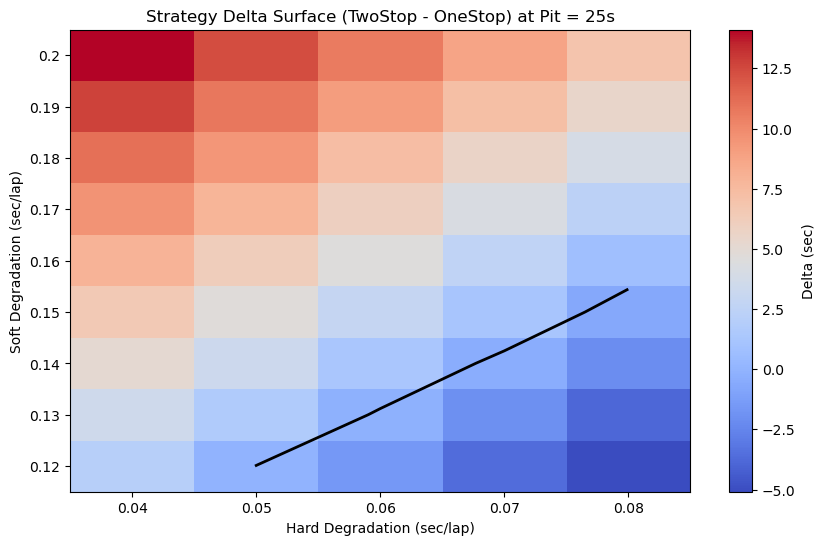

In [121]:
pivot_delta = grid_df.pivot(
    index="SoftDeg",
    columns="HardDeg",
    values="Delta"
)

plt.figure(figsize=(10,6))

im = plt.imshow(
    pivot_delta,
    aspect="auto",
    origin="lower",
    cmap="coolwarm"
)

plt.xticks(
    range(len(hard_deg_values)),
    [round(v,3) for v in hard_deg_values]
)

plt.yticks(
    range(len(soft_deg_values)),
    [round(v,3) for v in soft_deg_values]
)

plt.xlabel("Hard Degradation (sec/lap)")
plt.ylabel("Soft Degradation (sec/lap)")
plt.title("Strategy Delta Surface (TwoStop - OneStop) at Pit = 25s")

plt.colorbar(im, label="Delta (sec)")

plt.contour(pivot_delta, levels=[0], colors="black", linewidths=2)

plt.show()

- Incorporating traffic penalties and sustained undercut effects shifts the Bahrain strategic crossover boundary. 
- The 2-stop strategy becomes viable when pit delta falls below 21 seconds under moderate soft degradation (~0.12–0.14 sec/lap)

In [139]:
soft_deg = 0.13
hard_deg = 0.07
pit_time = 24

runs = 3000

res_1 = [simulate_race_with_soft_and_hard_deg(strategy_1, pit_time, soft_deg, hard_deg) for _ in range(runs)]
res_2 = [simulate_race_with_soft_and_hard_deg(strategy_2, pit_time, soft_deg, hard_deg) for _ in range(runs)]

win_prob = np.mean(np.array(res_2) < np.array(res_1))
win_prob

0.30766666666666664

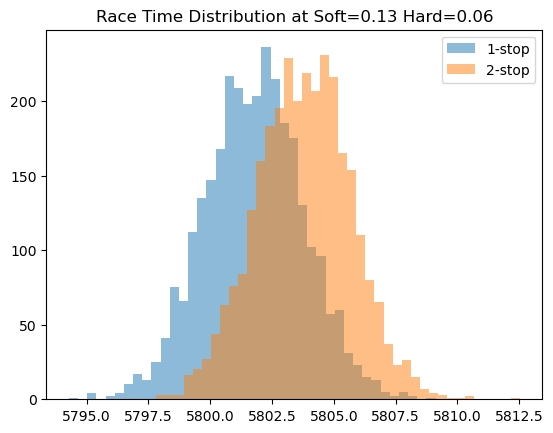

In [135]:
import matplotlib.pyplot as plt

plt.hist(res_1, bins=40, alpha=0.5, label="1-stop")
plt.hist(res_2, bins=40, alpha=0.5, label="2-stop")
plt.legend()
plt.title("Race Time Distribution at Soft=0.13 Hard=0.06")
plt.show()